# Competição ML @SBS/DAA - 5ª Edição (2022/2023)

Esta competição está relacionada com o Trabalho Prático de Grupo das UCs do perfil Machine Learning: Fundamentos e Aplicações da Uminho e da UC Dados e Aprendizagem Automática, tendo, como destinatários, alunos do Mestrado em Engenharia Informática, do Mestrado em Matemática e Computação, e do Mestrado em Engenharia de Sistemas.

# Descrição da Competição
A previsão da quantidade de incidentes rodoviários é um conhecido problema de características estocásticas, não-lineares. Tem, contudo, aparecido na literatura um conjunto de modelos que demonstram um potencial assinalável neste tipo de previsões. Com isso em consideração, foi construído um dataset que contém dados referentes à quantidade e características dos incidentes rodoviários que ocorreram na cidade de Guimarães em 2021 (o dataset cobre um período que vai desde o dia 01 de Janeiro de 2021 até ao dia 31 de Dezembro do mesmo ano).

Com esta competição espera-se que os alunos desenvolvam e otimizem modelos de Machine Learning que sejam capazes de prever o número de incidentes rodoviários que irão acontecer na cidade de Guimarães a uma determinada hora.

## Carregar variaveis de ambiente

In [ ]:
!conda install python-dotenv -y  # Correr isto para instalar as dependencias necessarias

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()

TRAIN_DATASET_SOURCE = os.environ.get("TRAIN_DATASET_SOURCE")

TEST_DATASET_SOURCE = os.environ.get("TEST_DATASET_SOURCE")


## Imports utilizados

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


%matplotlib inline

### Mudar o modo que a Interactive shell imprime as variáveis

In [3]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

## Loading the training dataset

In [4]:
train_df = pd.read_csv(os.path.basename(TRAIN_DATASET_SOURCE))

## Exploring

In [5]:
train_df.head()

train_df.describe()

train_df.info()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


,delay_in_seconds,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0
mean,560.567000,14.583000,1018.145000,74.455000,1.253500,0.0
std,1686.859581,4.820514,5.174372,17.204638,1.269847,0.0
min,0.000000,1.000000,997.000000,6.000000,0.000000,0.0
25%,0.000000,11.000000,1015.000000,63.000000,0.000000,0.0
50%,0.000000,14.000000,1019.000000,78.000000,1.000000,0.0
75%,234.000000,18.000000,1022.000000,90.000000,2.000000,0.0
max,31083.000000,35.000000,1032.000000,100.000000,10.000000,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           5000 non-null   object 
 1   magnitude_of_delay  5000 non-null   object 
 2   delay_in_seconds    5000 non-null   int64  
 3   affected_roads      4915 non-null   object 
 4   record_date         5000 non-null   object 
 5   luminosity          5000 non-null   object 
 6   avg_temperature     5000 non-null   float64
 7   avg_atm_pressure    5000 non-null   float64
 8   avg_humidity        5000 non-null   float64
 9   avg_wind_speed      5000 non-null   float64
 10  avg_precipitation   5000 non-null   float64
 11  avg_rain            5000 non-null   object 
 12  incidents           5000 non-null   object 
dtypes: float64(5), int64(1), object(7)
memory usage: 507.9+ KB


In [6]:
for column in train_df.columns:
    train_df[column].value_counts()

Guimaraes    5000
Name: city_name, dtype: int64

UNDEFINED    4314
MAJOR         678
MODERATE        8
Name: magnitude_of_delay, dtype: int64

0       3226
35        10
31         9
162        8
28         8
        ... 
5506       1
836        1
1690       1
585        1
896        1
Name: delay_in_seconds, Length: 1186, dtype: int64

N101,N101,N101,N101,N101                                                                                                                                      1514
N101,N101,N101,N101,N101,                                                                                                                                     1078
,                                                                                                                                                              709
N101,N101                                                                                                                                                      149
N101,N101,N101,N101,N101,N101                                                                                                                                  114
                                                                                                                                                              ... 
N101,N101,N105,N105,N1

2021-03-15 23:00    1
2021-10-29 07:00    1
2021-04-25 03:00    1
2021-03-17 17:00    1
2021-07-22 00:00    1
                   ..
2021-10-19 00:00    1
2021-10-22 23:00    1
2021-12-04 23:00    1
2021-09-13 23:00    1
2021-12-20 02:00    1
Name: record_date, Length: 5000, dtype: int64

DARK         2489
LIGHT        2325
LOW_LIGHT     186
Name: luminosity, dtype: int64

13.0    461
12.0    457
11.0    438
14.0    384
16.0    382
15.0    354
17.0    320
18.0    311
10.0    307
19.0    210
9.0     197
20.0    179
8.0     172
21.0    140
7.0     116
22.0    115
23.0    100
6.0      79
24.0     55
5.0      41
25.0     39
26.0     32
27.0     31
28.0     13
4.0      13
30.0     13
29.0     10
32.0      6
31.0      6
3.0       6
34.0      4
33.0      3
2.0       3
1.0       2
35.0      1
Name: avg_temperature, dtype: int64

1019.0    452
1018.0    393
1016.0    373
1020.0    362
1021.0    347
1022.0    338
1017.0    305
1015.0    299
1023.0    259
1024.0    236
1013.0    218
1025.0    205
1014.0    200
1010.0    148
1026.0    140
1012.0    135
1011.0    123
1027.0     82
1009.0     75
1008.0     62
1028.0     58
1007.0     52
1006.0     34
1030.0     20
1005.0     18
1029.0     15
1003.0     14
1004.0     12
1002.0      8
1031.0      5
1001.0      5
997.0       2
998.0       2
1000.0      1
1032.0      1
999.0       1
Name: avg_atm_pressure, dtype: int64

92.0    355
93.0    338
91.0    307
94.0    193
90.0    156
       ... 
8.0       2
6.0       1
7.0       1
21.0      1
18.0      1
Name: avg_humidity, Length: 83, dtype: int64

1.0     1745
0.0     1590
2.0      973
3.0      367
4.0      207
5.0       73
6.0       34
8.0        5
7.0        4
0.5        1
10.0       1
Name: avg_wind_speed, dtype: int64

0.0    5000
Name: avg_precipitation, dtype: int64

Sem Chuva         4756
chuva fraca        214
chuva moderada      27
chuva forte          3
Name: avg_rain, dtype: int64

None         2028
High         1073
Low           718
Very_High     603
Medium        578
Name: incidents, dtype: int64

In [7]:
train_df[['magnitude_of_delay', 'delay_in_seconds']]

,magnitude_of_delay,delay_in_seconds
0,UNDEFINED,0
1,UNDEFINED,385
2,UNDEFINED,69
3,MAJOR,2297
4,UNDEFINED,0
...,...,...
4995,UNDEFINED,0
4996,UNDEFINED,0
4997,UNDEFINED,0
4998,UNDEFINED,0


<AxesSubplot: >

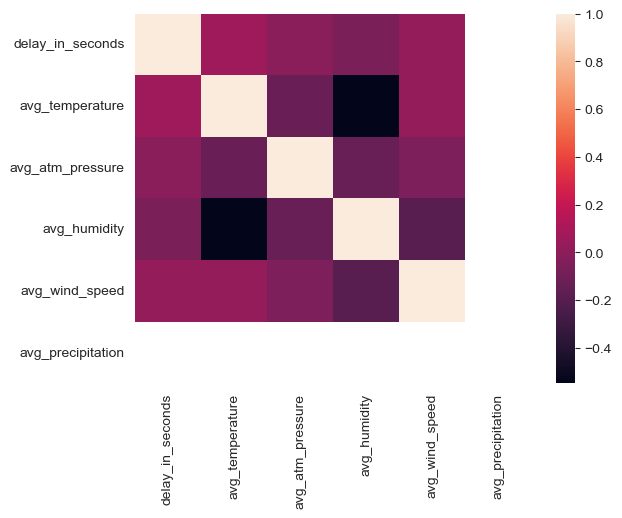

In [8]:
sns.heatmap(train_df.corr(numeric_only=True))

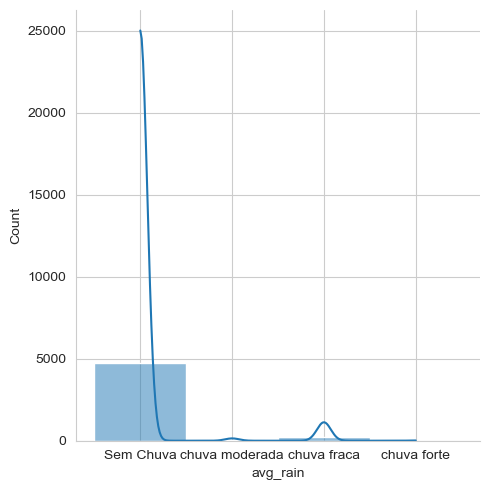

In [9]:
sns.displot(train_df['avg_rain'], kde=True)

<AxesSubplot: xlabel='avg_rain', ylabel='Count'>

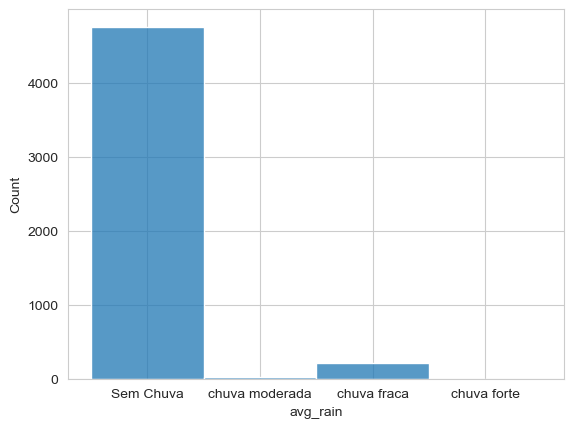

In [10]:
sns.histplot(train_df['avg_rain'])

In [11]:
train_df.groupby(by=['avg_rain', 'incidents']).count()

city_name  magnitude_of_delay  delay_in_seconds  \
avg_rain       incidents                                                    
Sem Chuva      High            1015                1015              1015   
               Low              681                 681               681   
               Medium           548                 548               548   
               None            1959                1959              1959   
               Very_High        553                 553               553   
chuva forte    Low                2                   2                 2   
               Very_High          1                   1                 1   
chuva fraca    High              50                  50                50   
               Low               32                  32                32   
               Medium            26                  26                26   
               None              67                  67                67   
               Very_High         39                  39                39   
chuva moderada High               8                   8                 8   
               Low                3                   3                 3   
               Medium             4                   4                 4   
               None               2                   2                 2   
               Very_High         10                  10                10   

                          affected_roads  record_date  luminosity  \
avg_rain       incidents                                            
Sem Chuva      High                 1008         1015        1015   
               Low                   629          681         681   
               Medium                537          548         548   
               None                 1949         1959        1959   
               Very_High             553          553         553   
chuva forte    Low                     2            2           2   
               Very_High               1            1           1   
chuva fraca    High                   50           50          50   
               Low                    29           32          32   
               Medium                 25           26          26   
               None                   67           67          67   
               Very_High              39           39          39   
chuva moderada High                    8            8           8   
               Low                     3            3           3   
               Medium                  3            4           4   
               None                    2            2           2   
               Very_High              10           10          10   

                          avg_temperature  avg_atm_pressure  avg_humidity  \
avg_rain       incidents                                                    
Sem Chuva      High                  1015              1015          1015   
               Low                    681               681           681   
               Medium                 548               548           548   
               None                  1959              1959          1959   
               Very_High              553               553           553   
chuva forte    Low                      2                 2             2   
               Very_High                1                 1             1   
chuva fraca    High                    50                50            50   
               Low                     32                32            32   
               Medium                  26                26            26   
               None                    67                67            67   
               Very_High               39                39            39   
chuva moderada High                     8                 8             8   
               Low                      3                 3             3   
               Med

## Data preparation

In [12]:
X = train_df.drop(['city_name', 'magnitude_of_delay', 'affected_roads', 'luminosity', 'avg_rain', 'incidents'], axis=1)

In [13]:
from sklearn import preprocessing

estimator = preprocessing.KBinsDiscretizer(n_bins=3, random_state=2021)

#X['delay_in_seconds_binned'] = pd.qcut(X['delay_in_seconds'], q=3)

In [14]:
record_date = pd.DatetimeIndex(X['record_date'])

X['record_date_hour'] = record_date.hour
X['record_date_weekday'] = record_date.weekday

X.drop(columns=['record_date'], inplace=True)

X

,delay_in_seconds,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,record_date_hour,record_date_weekday
0,0,12.0,1013.0,70.0,1.0,0.0,23,0
1,385,12.0,1007.0,91.0,1.0,0.0,18,5
2,69,14.0,1025.0,64.0,0.0,0.0,15,4
3,2297,15.0,1028.0,75.0,1.0,0.0,9,2
4,0,27.0,1020.0,52.0,1.0,0.0,11,6
...,...,...,...,...,...,...,...,...
4995,0,13.0,1021.0,56.0,0.0,0.0,0,1
4996,0,19.0,1017.0,68.0,0.0,0.0,14,1
4997,0,13.0,1023.0,47.0,2.0,0.0,3,3
4998,0,12.0,1014.0,93.0,2.0,0.0,6,1


In [15]:
y = train_df['incidents']

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

------

In [17]:
# Criar bins (experimentar) -> avg temperature
train_df.loc[train_df['avg_temperature'].between(10, 19, 'both'), 'temperature'] = 'MEAN'
train_df.loc[train_df['avg_temperature'].between(0, 10, 'right'), 'grade'] = 'LOW'
x = train_df.loc[train_df['avg_temperature'].between(19, 35, 'right'), 'grade'] = 'HIGH'

In [18]:
# Eliminar (initialmente) -> avg humidity
train_df.drop(['avg_humidity'], axis=1)

# Eliminar -> avg precipitation
train_df.drop(['avg_precipitation'], axis=1)

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_wind_speed,avg_precipitation,avg_rain,incidents,temperature,grade
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,1.0,0.0,Sem Chuva,None,MEAN,NaN
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,1.0,0.0,Sem Chuva,None,MEAN,NaN
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,0.0,0.0,Sem Chuva,Low,MEAN,NaN
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,1.0,0.0,Sem Chuva,Very_High,MEAN,NaN
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,1.0,0.0,Sem Chuva,High,NaN,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-04-13 00:00,DARK,13.0,1021.0,0.0,0.0,Sem Chuva,High,MEAN,NaN
4996,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-07-06 14:00,LIGHT,19.0,1017.0,0.0,0.0,Sem Chuva,None,MEAN,NaN
4997,Guimaraes,UNDEFINED,0,",",2021-03-18 03:00,DARK,13.0,1023.0,2.0,0.0,Sem Chuva,None,MEAN,NaN
4998,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-11-02 06:00,DARK,12.0,1014.0,2.0,0.0,Sem Chuva,None,MEAN,NaN


,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_rain,incidents,temperature,grade
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,Sem Chuva,None,MEAN,NaN
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,Sem Chuva,None,MEAN,NaN
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,Sem Chuva,Low,MEAN,NaN
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,Sem Chuva,Very_High,MEAN,NaN
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,Sem Chuva,High,NaN,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-04-13 00:00,DARK,13.0,1021.0,56.0,0.0,Sem Chuva,High,MEAN,NaN
4996,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-07-06 14:00,LIGHT,19.0,1017.0,68.0,0.0,Sem Chuva,None,MEAN,NaN
4997,Guimaraes,UNDEFINED,0,",",2021-03-18 03:00,DARK,13.0,1023.0,47.0,2.0,Sem Chuva,None,MEAN,NaN
4998,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-11-02 06:00,DARK,12.0,1014.0,93.0,2.0,Sem Chuva,None,MEAN,NaN


1.0     1745
0.0     1590
2.0      973
3.0      367
4.0      207
5.0       73
6.0       34
8.0        5
7.0        4
0.5        1
10.0       1
Name: avg_wind_speed, dtype: int64

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents,temperature,grade
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None,MEAN,NaN
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None,MEAN,NaN
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low,MEAN,NaN
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High,MEAN,NaN
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High,NaN,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-04-13 00:00,DARK,13.0,1021.0,56.0,0.0,0.0,Sem Chuva,High,MEAN,NaN
4996,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-07-06 14:00,LIGHT,19.0,1017.0,68.0,0.0,0.0,Sem Chuva,None,MEAN,NaN
4997,Guimaraes,UNDEFINED,0,",",2021-03-18 03:00,DARK,13.0,1023.0,47.0,2.0,0.0,Sem Chuva,None,MEAN,NaN
4998,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-11-02 06:00,DARK,12.0,1014.0,93.0,2.0,0.0,Sem Chuva,None,MEAN,NaN


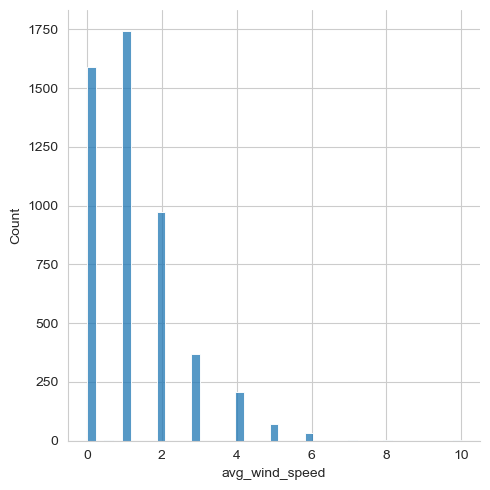

In [19]:
sns.displot(train_df['avg_wind_speed'])

train_df['avg_wind_speed'].value_counts()

# Remover outliners -> avg wind speed
# outliers = train_df["avg_wind_speed"].quantile(8.0)

train_df[train_df["avg_wind_speed"] < 8.0]

### Model Fitting

In [20]:
clf = DecisionTreeClassifier(random_state=2021)

clf.fit(X_train, y_train)

scores = cross_val_score(clf, X, y, cv=5)

DecisionTreeClassifier(random_state=2021)

In [21]:
predictions = clf.predict(X_test)

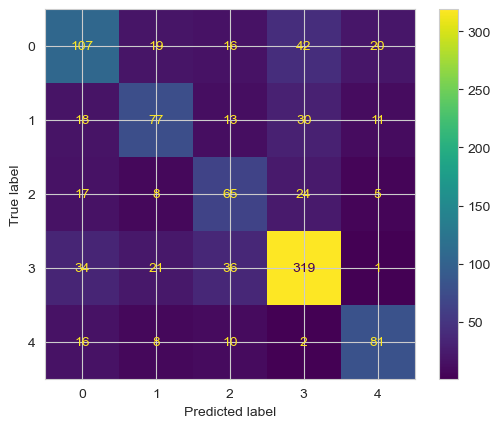

In [22]:
cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot()

In [23]:
accuracy_score(y_test, predictions)
# (TP + TN) / (TP + FP + FN + TN)

precision_score(y_test, predictions, average='micro')
# TP / (TP + FP)

recall_score(y_test, predictions, average='micro')
# TP / (TP + FN)

0.649

0.649

0.649

# Reading the test dataset

In [24]:
test_X = pd.read_csv(os.path.basename(TEST_DATASET_SOURCE))

test_X.head()
test_X.info()
test_X.describe()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain
0,Guimaraes,UNDEFINED,1211,"N101,N101,N101,N101,N101,N101,",2021-04-13 19:00,LIGHT,15.0,1018.0,80.0,0.0,0.0,Sem Chuva
1,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-10-13 04:00,DARK,16.0,1018.0,41.0,2.0,0.0,Sem Chuva
2,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-07-18 19:00,LIGHT,22.0,1017.0,71.0,0.0,0.0,Sem Chuva
3,Guimaraes,UNDEFINED,140,"N101,R206,N101,N101,N101,N101",2021-10-30 15:00,LIGHT,18.0,1008.0,81.0,3.0,0.0,Sem Chuva
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101",2021-10-18 10:00,LIGHT,20.0,1022.0,86.0,0.0,0.0,Sem Chuva


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   city_name           1206 non-null   object 
 1   magnitude_of_delay  1206 non-null   object 
 2   delay_in_seconds    1206 non-null   int64  
 3   affected_roads      1184 non-null   object 
 4   record_date         1206 non-null   object 
 5   luminosity          1206 non-null   object 
 6   avg_temperature     1206 non-null   float64
 7   avg_atm_pressure    1206 non-null   float64
 8   avg_humidity        1206 non-null   float64
 9   avg_wind_speed      1206 non-null   float64
 10  avg_precipitation   1206 non-null   float64
 11  avg_rain            1206 non-null   object 
dtypes: float64(5), int64(1), object(6)
memory usage: 113.2+ KB


,delay_in_seconds,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation
count,1206.000000,1206.000000,1206.000000,1206.000000,1206.000000,1206.0
mean,565.080431,14.649254,1018.024876,73.865672,1.332504,0.0
std,1584.544376,4.691180,5.338753,17.202341,1.337510,0.0
min,0.000000,2.000000,999.000000,7.000000,0.000000,0.0
25%,0.000000,11.000000,1015.000000,62.000000,0.000000,0.0
50%,0.000000,14.000000,1018.000000,77.000000,1.000000,0.0
75%,268.750000,18.000000,1022.000000,90.000000,2.000000,0.0
max,14866.000000,30.000000,1031.000000,100.000000,9.000000,0.0


## Preparing the test data

In [26]:
test_X.drop(['city_name', 'magnitude_of_delay', 'affected_roads', 'luminosity', 'avg_rain'], axis=1, inplace=True)

record_date = pd.DatetimeIndex(test_X['record_date'])

test_X['record_date_hour'] = record_date.hour
test_X['record_date_weekday'] = record_date.weekday

test_X.drop(columns=['record_date'], inplace=True);

In [27]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   delay_in_seconds     1206 non-null   int64  
 1   avg_temperature      1206 non-null   float64
 2   avg_atm_pressure     1206 non-null   float64
 3   avg_humidity         1206 non-null   float64
 4   avg_wind_speed       1206 non-null   float64
 5   avg_precipitation    1206 non-null   float64
 6   record_date_hour     1206 non-null   int64  
 7   record_date_weekday  1206 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 75.5 KB


# Getting the predictions

In [33]:
predictions = clf.predict(test_X)

predictions_df = pd.DataFrame(predictions)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Incidents'], index_label='RowId')